In [1]:
import sys
import cv
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tippy.segmentations as se
import tippy.basic_operations as bo
import tippy.display_operations as do
from skfuzzy import control as ctrl
from sklearn.metrics import confusion_matrix
from PIL import Image
from skimage import morphology as morph
from scipy import misc
from scipy import ndimage
from time import time
from itertools import compress

In [2]:
# Sørensen–Dice

def dice(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    if ref1.shape != img.shape:
        raise ValueError("Shape mismatch: ref and img must have the same shape")
    
    TP = np.logical_and(ref1,img) # TRUE POSITIVE (interseção das imagens)
    
    return (2.0*TP.sum()) / (ref1.sum() + img.sum())

In [3]:
# Jaccard

def jaccard(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    if ref1.shape != img.shape:
        raise ValueError("Shape mismatch: ref and img must have the same shape")
        
    TP = np.logical_and(ref1,img) # TRUE POSITIVE (interseção das imagens)
    return (TP.sum())*1.0 / (ref1.sum() + img.sum() - TP.sum())

In [4]:
# confusion_matrix

def conf_matrix(ref1, img):
    ref1 = np.asarray(ref1).astype(np.bool)
    img = np.asarray(img).astype(np.bool)
    
    cm = confusion_matrix(ref1, img)    
    total = sum(sum(cm))
    
    TP = cm[1,1]
    TN = cm[0,0]
    FN = cm[1,0]
    FP = cm[0,1]
       
    accuracy = (TP*1.0 + TN) / total
    sensitivity = TP*1.0 / (TP+FN)
    specificity = TN*1.0 / (TN+FP)
    return(accuracy, sensitivity, specificity)

In [5]:
def calc_estatistica(ref1, img):
    dice1 = dice(ref1, img)
    jacc1 = jaccard(ref1, img)
    conf1 = conf_matrix(ref1.flatten(), img.flatten())
    return([dice1, jacc1, conf1[0], conf1[1], conf1[2]])

In [6]:
def junta_imgs(ref1, img1, img2):
    start = time()
    
    ref1 = np.asarray(ref1).astype(np.bool)
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    
    img_final = np.logical_or(img1, img2)
    
    lista = calc_estatistica(ref1, img_final)
    
    tempo_final = time() - start
    
    return(img_final, lista[0], lista[1], lista[2], lista[3], lista[4], tempo_final)

In [7]:
def fuzzySystem_OP(pixel, vm):

    # pixelIN variables
    x_pixelIN = np.linspace(0, 1, 100)
    x_pixelOUT  = np.linspace(0, 1, 100)

    # Generate fuzzy membership functions
    pixelIN_sm = fuzz.trapmf(x_pixelIN, [0, 0, 0.15*vm, 0.6*vm])
    pixelIN_md = fuzz.trimf(x_pixelIN, [0.5*vm, vm, 1.4*vm])
    pixelIN_la = fuzz.trapmf(x_pixelIN, [1.3*vm, 1.6*vm, 1, 1])
    
    pixelOUT_sm = fuzz.trapmf(x_pixelOUT, [0, 0, 0.05, 0.1])
    pixelOUT_md = fuzz.trimf(x_pixelOUT, [0.45, 0.5, 0.55])
    pixelOUT_la = fuzz.trapmf(x_pixelOUT, [0.9, 0.95, 1, 1])
    
    # Activation of fuzzy membership functions at vm using fuzz.interp_membership 
    pixelIN_level_sm = fuzz.interp_membership(x_pixelIN, pixelIN_sm, pixel)
    pixelIN_level_md = fuzz.interp_membership(x_pixelIN, pixelIN_md, pixel)
    pixelIN_level_la = fuzz.interp_membership(x_pixelIN, pixelIN_la, pixel)

    # Rules for OP
    rule1 = np.fmin(pixelIN_level_sm, pixelOUT_sm) # edge
    rule2 = np.fmin(pixelIN_level_md, pixelOUT_la) # liver
    rule3 = np.fmin(pixelIN_level_la, pixelOUT_md) # vessel
    
    # Aggregating the output membership functions
    aggregated = np.fmax(rule1, np.fmax(rule2, rule3))
    
    # Calculating the result
    output = fuzz.defuzz(x_pixelOUT, aggregated, 'centroid')
    output_activation = fuzz.interp_membership(x_pixelOUT, aggregated, output) # for plot
    
    return(output)

def fuzzySystem_IP(pixel, vm):

    # pixelIN variables
    x_pixelIN = np.linspace(0, 1, 100)
    x_pixelOUT  = np.linspace(0, 1, 100)

    # Generate fuzzy membership functions
    pixelIN_sm = fuzz.trapmf(x_pixelIN, [0, 0, 0.15*vm, 0.9*vm])
    pixelIN_md = fuzz.trimf(x_pixelIN, [0.87*vm, vm, 1.3*vm])
    pixelIN_la = fuzz.trapmf(x_pixelIN, [1.2*vm, 1.6*vm, 1, 1])

    pixelOUT_sm = fuzz.trapmf(x_pixelOUT, [0, 0, 0.05, 0.1])
    pixelOUT_md = fuzz.trimf(x_pixelOUT, [0.45, 0.5, 0.55])
    pixelOUT_la = fuzz.trapmf(x_pixelOUT, [0.9, 0.95, 1, 1])

    # Activation of fuzzy membership functions at vm using fuzz.interp_membership 
    pixelIN_level_sm = fuzz.interp_membership(x_pixelIN, pixelIN_sm, pixel)
    pixelIN_level_md = fuzz.interp_membership(x_pixelIN, pixelIN_md, pixel)
    pixelIN_level_la = fuzz.interp_membership(x_pixelIN, pixelIN_la, pixel)
    
    # Rules for IP
    rule1 = np.fmin(pixelIN_level_sm, pixelOUT_md) # vessel
    rule2 = np.fmin(pixelIN_level_md, pixelOUT_la) # liver
    rule3 = np.fmin(pixelIN_level_la, pixelOUT_sm) # edge
    
    # Aggregating the output membership functions
    aggregated = np.fmax(rule1, np.fmax(rule2, rule3))
    
    # Calculating the result
    output = fuzz.defuzz(x_pixelOUT, aggregated, 'centroid')
    output_activation = fuzz.interp_membership(x_pixelOUT, aggregated, output) # for plot
    
    return(output)

In [8]:
def fuzzy_seg(imgOP_orig, imgIP_orig, ref, vmed_op, vmed_ip, seed, indices_list):

    ###############################################################################
    '''
    pixelOP = np.genfromtxt("dataset01\s01-27-op-231-94-102.txt")
    pixelIP = np.genfromtxt("dataset01\s01-27-ip-432.txt")
    ref = np.genfromtxt("dataset01\s01-25-ref.txt")

    vmed_op = 231.0
    vmed_ip = 432.0
    seed = (94,102)
    '''
    ###############################################################################

    vmed_op = vmed_op/4095.0
    vmed_ip = vmed_ip/4095.0
    
    imgOP = np.zeros(imgOP_orig.shape)
    imgIP = np.zeros(imgIP_orig.shape)

    pixelOP = imgOP_orig*(1.0/4095.0)
    pixelIP = imgIP_orig*(1.0/4095.0)
    
    for i in (indices_list):
        imgOP[i] = fuzzySystem_OP(pixelOP[i], vmed_op)

    for i in (indices_list):
        imgIP[i] = fuzzySystem_IP(pixelIP[i], vmed_ip)
    
    plt.imshow(imgOP)
    plt.show()
    
    plt.imshow(imgIP)
    plt.show()
    
    ###############################################################################
    
    maskOP = imgOP > 0.6
    maskIP = imgIP > 0.6
       
    maskAND = np.logical_and(maskOP, maskIP)
    maskerosion = morph.binary_erosion(maskAND)
    maskopen = morph.binary_opening(maskerosion)
    
    plt.imshow(maskopen)
    plt.show()
    
    misc.imsave('maskfinal.bmp', maskopen)

    ###############################################################################

    user_input = 0

    img_name = "maskfinal.bmp"
    threshold = 20
    img = cv.LoadImage(img_name, cv.CV_LOAD_IMAGE_GRAYSCALE)
    out_img = se.simple_region_growing(img, seed, threshold)
    out_img = np.asarray(out_img[:,:])
   
    return out_img

In [9]:
def simple_region_growing(img, seed, threshold=1):
    """
    A (very) simple implementation of region growing.
    Extracts a region of the input image depending on a start position and a stop condition.
    The input should be a single channel 8 bits image and the seed a pixel position (x, y).
    The threshold corresponds to the difference between outside pixel intensity and mean intensity of region.
    In case no new pixel is found, the growing stops.
    Outputs a single channel 8 bits binary (0 or 255) image. Extracted region is highlighted in white.
    """

    try:
        dims = cv.GetSize(img)
    except TypeError:
        raise TypeError("(%s) img : IplImage expected!" % (sys._getframe().f_code.co_name))

    # img test
    if not(img.depth == cv.IPL_DEPTH_8U):
        raise TypeError("(%s) 8U image expected!" % (sys._getframe().f_code.co_name))
    elif not(img.nChannels is 1):
        raise TypeError("(%s) 1C image expected!" % (sys._getframe().f_code.co_name))
    # threshold tests
    if (not isinstance(threshold, int)) :
        raise TypeError("(%s) Int expected!" % (sys._getframe().f_code.co_name))
    elif threshold < 0:
        raise ValueError("(%s) Positive value expected!" % (sys._getframe().f_code.co_name))
    # seed tests
    if not((isinstance(seed, tuple)) and (len(seed) is 2) ) :
        raise TypeError("(%s) (x, y) variable expected!" % (sys._getframe().f_code.co_name))

    if (seed[0] or seed[1] ) < 0 :
        raise ValueError("(%s) Seed should have positive values!" % (sys._getframe().f_code.co_name))
    elif ((seed[0] > dims[0]) or (seed[1] > dims[1])):
        raise ValueError("(%s) Seed values greater than img size!" % (sys._getframe().f_code.co_name))

    reg = cv.CreateImage( dims, cv.IPL_DEPTH_8U, 1)
    cv.Zero(reg)

    #parameters
    mean_reg = float(img[seed[1], seed[0]])
    size = 1
    pix_area = dims[0]*dims[1]

    contour = [] # will be [ [[x1, y1], val1],..., [[xn, yn], valn] ]
    contour_val = []
    dist = 0
    # TODO: may be enhanced later with 8th connectivity
    orient = [(1, 0), (0, 1), (-1, 0), (0, -1)] # 4 connectivity
    cur_pix = [seed[0], seed[1]]

    #Spreading
    while(dist<threshold and size<pix_area):
    #adding pixels
        for j in range(4):
            #select new candidate
            temp_pix = [cur_pix[0] +orient[j][0], cur_pix[1] +orient[j][1]]

            #check if it belongs to the image
            is_in_img = dims[0]>temp_pix[0]>0 and dims[1]>temp_pix[1]>0 #returns boolean
            #candidate is taken if not already selected before
            if (is_in_img and (reg[temp_pix[1], temp_pix[0]]==0)):
                contour.append(temp_pix)
                contour_val.append(img[temp_pix[1], temp_pix[0]] )
                reg[temp_pix[1], temp_pix[0]] = 150
        #add the nearest pixel of the contour in it
        dist = abs(int(np.mean(contour_val)) - mean_reg)

        dist_list = [abs(i - mean_reg) for i in contour_val ]
        dist = min(dist_list)    #get min distance
        index = dist_list.index(min(dist_list)) #mean distance index
        size += 1 # updating region size
        reg[cur_pix[1], cur_pix[0]] = 255

        #updating mean MUST BE FLOAT
        mean_reg = (mean_reg*size + float(contour_val[index]))/(size+1)
        #updating seed
        cur_pix = contour[index]

        #removing pixel from neigborhood
        del contour[index]
        del contour_val[index]

    return reg

In [10]:
def true_Indices(imgCV, seed, threshold=15):
    pre_grow_cv = se.simple_region_growing(imgCV, seed, threshold)
    pre_grow = np.asarray(pre_grow_cv[:,:]).astype(np.bool)
    #plt.imshow(pre_grow, cmap='gray')
    #plt.show()
           
    pre_grow_dim = pre_grow.shape
    pre_grow_flat = pre_grow.flatten()
    
    true_indices_flat = list(compress(xrange(len(pre_grow_flat)), pre_grow_flat))
    true_indices = np.unravel_index(true_indices_flat,pre_grow_dim)
    return zip(true_indices[0],true_indices[1])

In [11]:
def start_segm(op, ip, ref):
    start = time()
    
    user_input = 0
        
    #get seeds from user
    misc.imsave('inputOP.bmp', op) #saves OP image as bitmap to be used by CV
    img_name = "inputOP.bmp"
    img = cv.LoadImage(img_name, cv.CV_LOAD_IMAGE_GRAYSCALE)
    inputseeds = bo.mouse_point(img, mode="M") # waits for user click to get seed, returns tuple inside a list
    print inputseeds    
    
    #get max, min and mean grey values from seeds
    grey_valueOP = []
    grey_valueIP = []
    for tuples in inputseeds:
        grey_valueOP = np.append(grey_valueOP, op[tuples[1],tuples[0]])
        grey_valueIP = np.append(grey_valueIP, ip[tuples[1],tuples[0]])
    
    ################################################################################################################
    
    #para fuzzy com vm = max
    grey_max_OP = np.max(grey_valueOP)
    grey_max_IP = np.max(grey_valueIP)
    seed_max = inputseeds[np.argmax(grey_valueOP)] #get the seed  (y,x) corresponding to the max grey value
    print seed_max
    true_idx_max = true_Indices(img, seed_max)
    result_max = fuzzy_seg(inputOP, inputIP, inputref, grey_max_OP, grey_max_IP, seed_max, true_idx_max)
     
    #para fuzzy com vm = min
    grey_min_OP = np.min(grey_valueOP)
    grey_min_IP = np.min(grey_valueIP)
    seed_min = inputseeds[np.argmin(grey_valueOP)] #get the seed  (y,x) corresponding to the minimum grey value
    print seed_min
    true_idx_min = true_Indices(img, seed_min)
    result_min = fuzzy_seg(inputOP, inputIP, inputref, grey_min_OP, grey_min_IP, seed_min, true_idx_min)
    
        
    #para fuzzy com vm = mean
    grey_mean_OP = np.mean(grey_valueOP)
    grey_mean_IP = np.mean(grey_valueIP)
    seed_mean = inputseeds[min(range(len(grey_valueOP)), key=lambda i: abs(grey_valueOP[i]-grey_mean_OP))] #get the seed  (y,x)
    print seed_mean
    true_idx_mean = true_Indices(img, seed_mean)
    result_mean = fuzzy_seg(inputOP, inputIP, inputref, grey_mean_OP, grey_mean_IP, seed_mean, true_idx_mean)
    
    ################################################################################################################
   
    combined_result = np.logical_or(np.logical_or(result_min,result_mean),result_max)
   
    ################################################################################################################
    
    # plot
    f, axarr = plt.subplots(2,2,figsize=(10,10))
    
    axarr[0,0].imshow(op, cmap='gray')
    axarr[0,0].set_title('OP')
    
    axarr[0,1].imshow(ip, cmap='gray')
    axarr[0,1].set_title('IP')
    
    axarr[1,0].imshow(ref, cmap='gray')
    axarr[1,0].set_title('Reference')
    
    axarr[1,1].imshow(combined_result, cmap='gray')
    axarr[1,1].set_title('Result')
    
    plt.show()
    
    ''' 
    plt.imshow(ref, cmap='gray')
    plt.title('ref')
    plt.show()

    plt.imshow(maskOP, cmap='gray')
    plt.title('maskOP')
    plt.show()

    plt.imshow(maskIP, cmap='gray')
    plt.title('maskIP')
    plt.show()

    plt.imshow(maskAND, cmap='gray')
    plt.title('maskAND')
    plt.show()

    plt.imshow(maskopen, cmap='gray')
    plt.title('maskopen')
    plt.show()

    plt.imshow(out_img, cmap='gray')
    plt.title('result')
    plt.show()'''
    
    lista = calc_estatistica(ref, combined_result)
    tempo_final = time() - start
    
    del(inputseeds)
    del(seed_max)
    del(seed_min)
    del(seed_mean)
    
    return(combined_result, lista[0], lista[1], lista[2], lista[3], lista[4], tempo_final)

## S03

In [12]:
listaDICE_S01_19 = []
listaJACC_S01_19 = []
listaACCU_S01_19 = []
listaSENS_S01_19 = []
listaSPEC_S01_19 = []
listaTEMPO_S01_19 = []

[(105, 235)]
(105, 235)


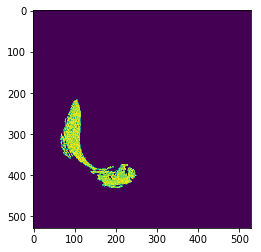

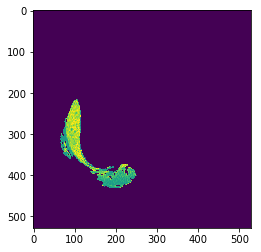

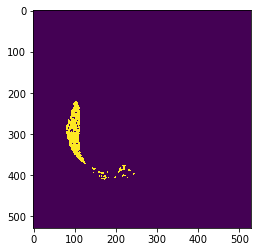

(105, 235)


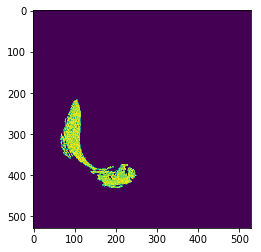

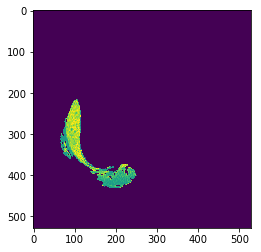

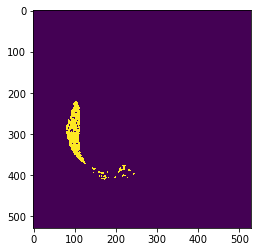

(105, 235)


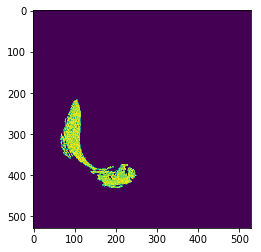

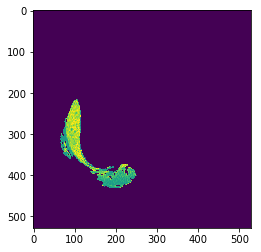

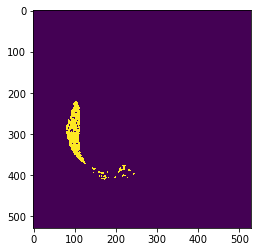

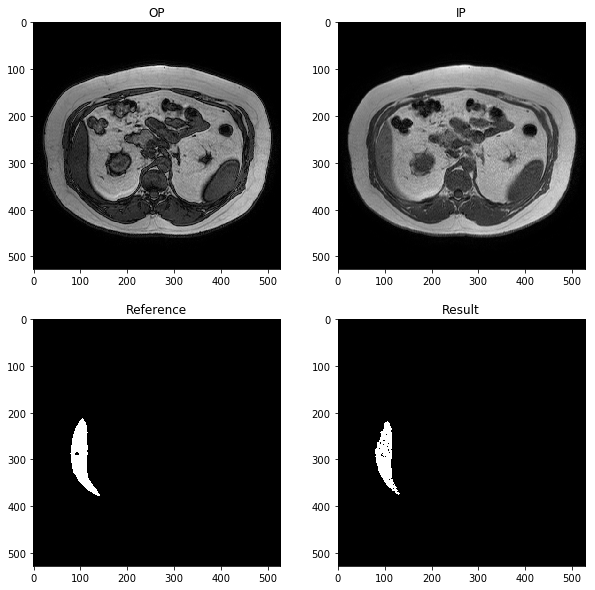

10
10
10
10
10
10


In [28]:
# S01-51

inputOP = np.genfromtxt("dataset03\s05-19-op-82-235.txt")
inputIP = np.genfromtxt("dataset03\s05-19-ip-20-75.txt")
inputref = np.genfromtxt("dataset03\s05-19-ref.txt")

result_s01_19, dice_f19, jacc_f19, accu_f19, sens_f19, spec_f19, tempo_f19 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s03_19_10.bmp', result_s01_19)

listaDICE_S01_19.append(dice_f19)
listaJACC_S01_19.append(jacc_f19)
listaACCU_S01_19.append(accu_f19)
listaSENS_S01_19.append(sens_f19)
listaSPEC_S01_19.append(spec_f19)
listaTEMPO_S01_19.append(tempo_f19)

print(len(listaDICE_S01_19))
print(len(listaJACC_S01_19))
print(len(listaACCU_S01_19))
print(len(listaSENS_S01_19))
print(len(listaSPEC_S01_19))
print(len(listaTEMPO_S01_19))

del(inputOP)
del(inputIP)
del(inputref)

In [56]:
print np.mean(listaDICE_S01_19)
print np.mean(listaJACC_S01_19)
print np.mean(listaACCU_S01_19)
print np.mean(listaSENS_S01_19)
print np.mean(listaSPEC_S01_19)
print np.mean(listaTEMPO_S01_19)

0.888492949459
0.79946880193
0.996712867309
0.815509930819
0.999672989358
51.2607000351


In [29]:
listaDICE_S01_21 = []
listaJACC_S01_21 = []
listaACCU_S01_21 = []
listaSENS_S01_21 = []
listaSPEC_S01_21 = []
listaTEMPO_S01_21 = []

[(107, 246), (109, 318)]
(109, 318)


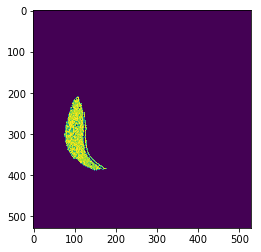

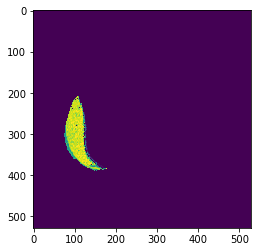

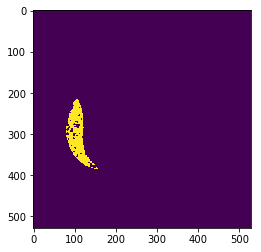

(107, 246)


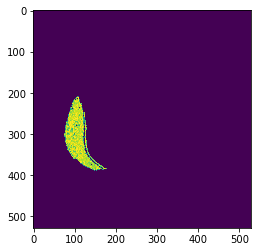

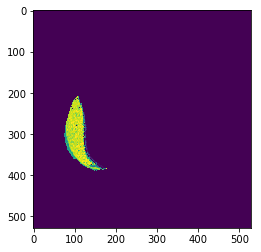

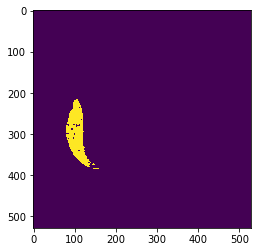

(107, 246)


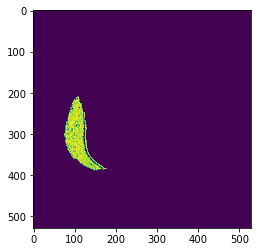

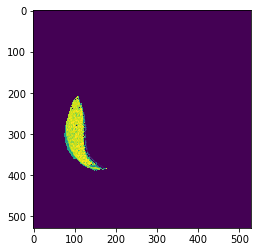

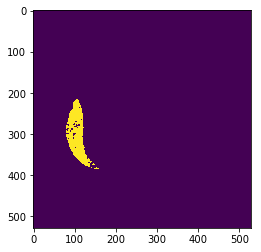

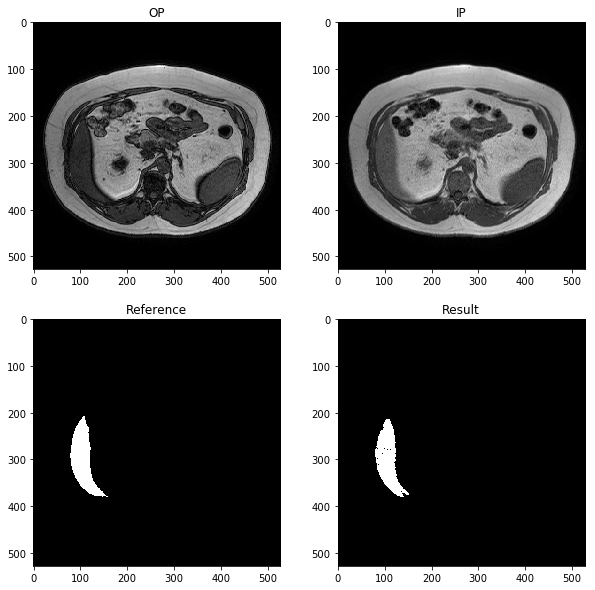

10
10
10
10
10
10


In [39]:
# S01-21

inputOP = np.genfromtxt("dataset03\s05-21-op.txt")
inputIP = np.genfromtxt("dataset03\s05-21-ip.txt")
inputref = np.genfromtxt("dataset03\s05-21-ref.txt")

result_s01_21, dice_f21, jacc_f21, accu_f21, sens_f21, spec_f21, tempo_f21 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s03_21_10.bmp', result_s01_21)

listaDICE_S01_21.append(dice_f21)
listaJACC_S01_21.append(jacc_f21)
listaACCU_S01_21.append(accu_f21)
listaSENS_S01_21.append(sens_f21)
listaSPEC_S01_21.append(spec_f21)
listaTEMPO_S01_21.append(tempo_f21)

print(len(listaDICE_S01_21))
print(len(listaJACC_S01_21))
print(len(listaACCU_S01_21))
print(len(listaSENS_S01_21))
print(len(listaSPEC_S01_21))
print(len(listaTEMPO_S01_21))

del(inputOP)
del(inputIP)
del(inputref)

In [57]:
print np.mean(listaDICE_S01_21)
print np.mean(listaJACC_S01_21)
print np.mean(listaACCU_S01_21)
print np.mean(listaSENS_S01_21)
print np.mean(listaSPEC_S01_21)
print np.mean(listaTEMPO_S01_21)

0.942836935922
0.89188141807
0.997715794307
0.911292281006
0.999540691307
43.1689999819


In [64]:
listaDICE_S01_29 = []
listaJACC_S01_29 = []
listaACCU_S01_29 = []
listaSENS_S01_29 = []
listaSPEC_S01_29 = []
listaTEMPO_S01_29 = []

[(112, 238)]
(112, 238)


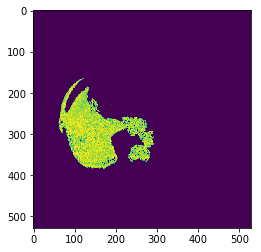

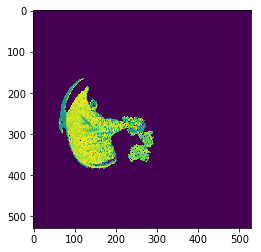

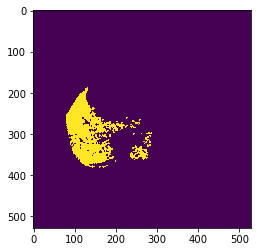

(112, 238)


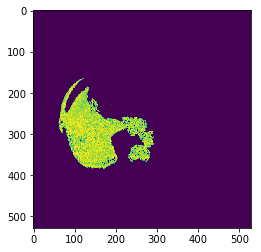

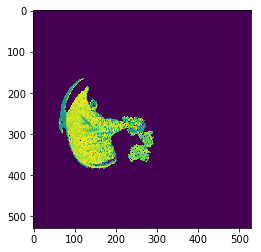

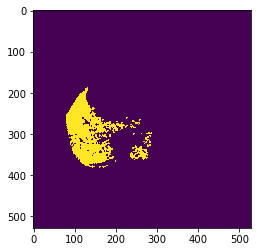

(112, 238)


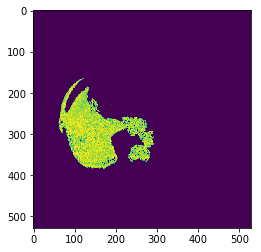

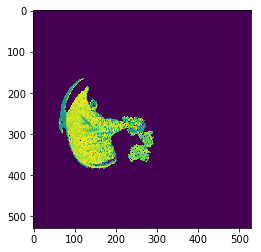

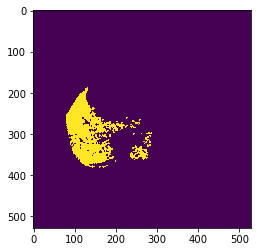

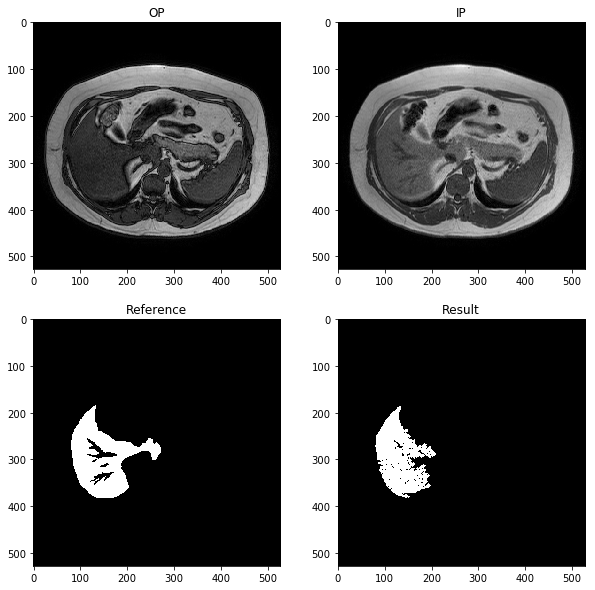

3
3
3
3
3
3


In [67]:
# S01-29

inputOP = np.genfromtxt("dataset03\s05-29-op.txt")
inputIP = np.genfromtxt("dataset03\s05-29-ip.txt")
inputref = np.genfromtxt("dataset03\s05-29-ref.txt")

result_s01_29, dice_f29, jacc_f29, accu_f29, sens_f29, spec_f29, tempo_f29 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s03_29_3.bmp', result_s01_29)

listaDICE_S01_29.append(dice_f29)
listaJACC_S01_29.append(jacc_f29)
listaACCU_S01_29.append(accu_f29)
listaSENS_S01_29.append(sens_f29)
listaSPEC_S01_29.append(spec_f29)
listaTEMPO_S01_29.append(tempo_f29)

print(len(listaDICE_S01_29))
print(len(listaJACC_S01_29))
print(len(listaACCU_S01_29))
print(len(listaSENS_S01_29))
print(len(listaSPEC_S01_29))
print(len(listaTEMPO_S01_29))

del(inputOP)
del(inputIP)
del(inputref)

In [ ]:
print np.mean(listaDICE_S01_29)
print np.mean(listaJACC_S01_29)
print np.mean(listaACCU_S01_29)
print np.mean(listaSENS_S01_29)
print np.mean(listaSPEC_S01_29)
print np.mean(listaTEMPO_S01_29)

In [58]:
listaDICE_S01_37 = []
listaJACC_S01_37 = []
listaACCU_S01_37 = []
listaSENS_S01_37 = []
listaSPEC_S01_37 = []
listaTEMPO_S01_37 = []

[(189, 365), (121, 211)]
(189, 365)


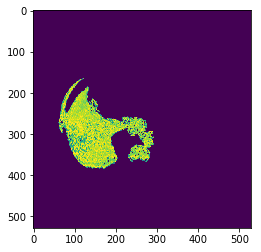

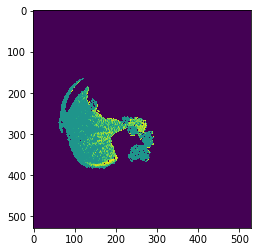

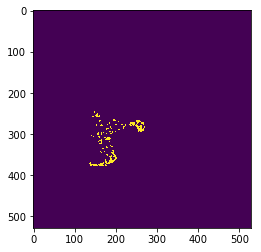

(121, 211)


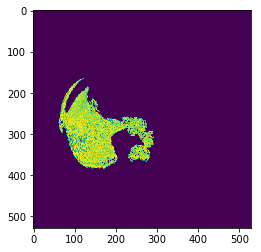

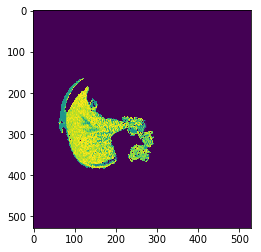

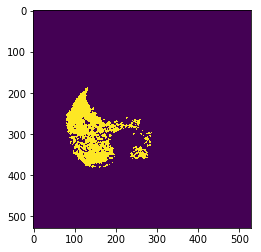

(189, 365)


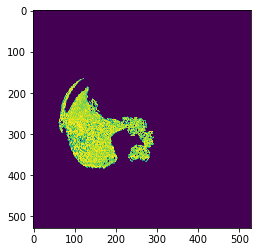

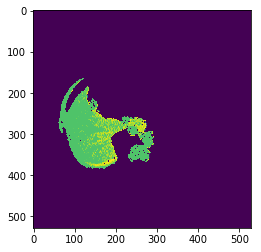

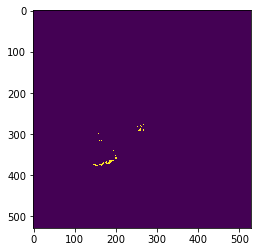

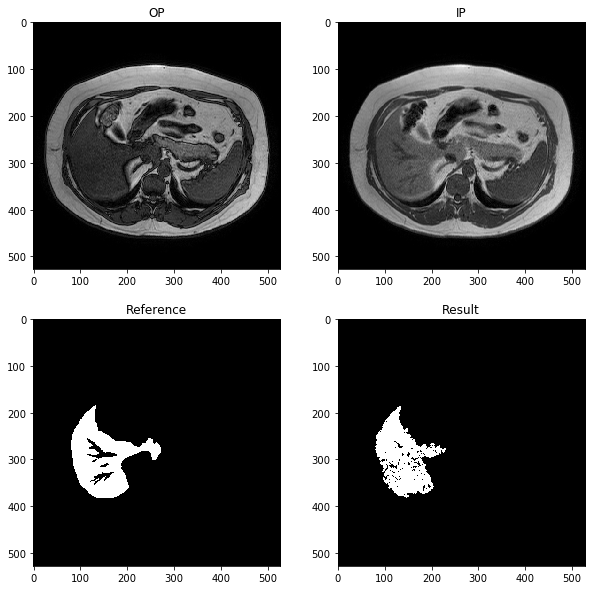

1
1
1
1
1
1


In [59]:
# S01-37

inputOP = np.genfromtxt("dataset03\s05-29-op.txt")
inputIP = np.genfromtxt("dataset03\s05-29-ip.txt")
inputref = np.genfromtxt("dataset03\s05-29-ref.txt")

result_s01_37, dice_f37, jacc_f37, accu_f37, sens_f37, spec_f37, tempo_f37 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s03_37_1.bmp', result_s01_37)

listaDICE_S01_37.append(dice_f37)
listaJACC_S01_37.append(jacc_f37)
listaACCU_S01_37.append(accu_f37)
listaSENS_S01_37.append(sens_f37)
listaSPEC_S01_37.append(spec_f37)
listaTEMPO_S01_37.append(tempo_f37)

print(len(listaDICE_S01_37))
print(len(listaJACC_S01_37))
print(len(listaACCU_S01_37))
print(len(listaSENS_S01_37))
print(len(listaSPEC_S01_37))
print(len(listaTEMPO_S01_37))

del(inputOP)
del(inputIP)
del(inputref)

In [60]:
plt.imshow(inputref)
plt.show()

NameError: name 'inputref' is not defined

In [ ]:
print np.mean(listaDICE_S01_37)
print np.mean(listaJACC_S01_37)
print np.mean(listaACCU_S01_37)
print np.mean(listaSENS_S01_37)
print np.mean(listaSPEC_S01_37)
print np.mean(listaTEMPO_S01_37)

In [ ]:
listaDICE_S01_41 = []
listaJACC_S01_41 = []
listaACCU_S01_41 = []
listaSENS_S01_41 = []
listaSPEC_S01_41 = []
listaTEMPO_S01_41 = []

In [ ]:
# S01-41

inputOP = np.genfromtxt("dataset03\s05-29-op.txt")
inputIP = np.genfromtxt("dataset03\s05-29-ip.txt")
inputref = np.genfromtxt("dataset03\s05-29-ref.txt")

result_s01_41, dice_f41, jacc_f41, accu_f41, sens_f41, spec_f41, tempo_f41 = start_segm(inputOP, inputIP, inputref)

misc.imsave('result_s03_41_1.bmp', result_s01_41)

listaDICE_S01_41.append(dice_f41)
listaJACC_S01_41.append(jacc_f41)
listaACCU_S01_41.append(accu_f41)
listaSENS_S01_41.append(sens_f31)
listaSPEC_S01_41.append(spec_f41)
listaTEMPO_S01_41.append(tempo_f41)

print(len(listaDICE_S01_41))
print(len(listaJACC_S01_41))
print(len(listaACCU_S01_41))
print(len(listaSENS_S01_41))
print(len(listaSPEC_S01_41))
print(len(listaTEMPO_S01_41))

del(inputOP)
del(inputIP)
del(inputref)

In [ ]:
print np.mean(listaDICE_S01_41)
print np.mean(listaJACC_S01_41)
print np.mean(listaACCU_S01_41)
print np.mean(listaSENS_S01_41)
print np.mean(listaSPEC_S01_41)
print np.mean(listaTEMPO_S01_41)

In [ ]:
DICET = listaDICE_S01_19 + listaDICE_S01_21 + listaDICE_S01_37
JACCT = 
ACCUT = 
SENST = 
SPECT = 
TEMPOT = 

In [63]:
del listaDICE_S01_29
del listaJACC_S01_29
del listaACCU_S01_29
del listaSENS_S01_29
del listaSPEC_S01_29
del listaTEMPO_S01_29

NameError: name 'listaDICE_S01_29' is not defined